# **INSURANCE PROJECT**

Authors: 

# ⚙️ Setting Parameters

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)  # Seed for reproducibility

# setting given parameters
F0 = 70000 # initial value of the fund
C0 = 70000 # initial value of the invested premium

equityp = 0.8 # percentage of equity in the fund
propertyp = 0.2 # percentage of property in the fund
sigma_equity = 0.20 # equity volatility
sigma_property = 0.10 # property volatility

EQ0 = F0 * equityp  # computing the initial value of equity
PR0 = F0 * propertyp  # computing the initial value of property

RD = 2.2/100 # Regular Deduction
COMM = 1.4/100 # commisions to the distribution channels
T = 50 # Time horizon for projections
t = np.arange(1, T + 1)  # time discretization

lt = 15/100 # costant annual lapse rate
lapse = np.ones((T - 1)) * lt
# setting the lapse rate as vector (for easier computations in the implemented functions)
lapse = np.append(lapse,1)
# the last values has been set as 1 for massive surrender after 50 years

lapse_p = 20  # penalty lapse
inflation_rate = 2/100  # annual inflation rate
expenses = 50

inflation_factors = (1 + inflation_rate) ** t
inflated_lapse = lapse_p * inflation_factors
lapse_penalties  = np.concatenate(([lapse_p], inflated_lapse))
inflated_expenses = expenses * inflation_factors
expenses_inflation = np.concatenate(([expenses], inflated_expenses)) # cost of 50 euros per year growing for inflation factor


# 🛠️ FUNCTIONS

**Monte Carlo simulation Function**

In [61]:
from scipy.stats import norm

def MonteCarlo(S0, RD, R_fwd, sigma, T, NMC):
    """
    Simulates asset values using the Geometric Brownian Motion (GBM) model.

    Parameters:
    - S0 : float, initial value of the asset
    - RD : float, regular deduction rate (e.g., 0.02 for 2%)
    - R_fwd : array-like, forward rates for each time step
    - sigma : float, volatility
    - T : float, total time horizon
    - NMC : int, number of Monte Carlo simulations

    Returns:
    - St : NumPy array of shape (NMC, n+1), simulated asset values over time
    - CFInt : NumPy array of shape (n+1, 2), 97.5% confidence intervals
    """
    
    np.random.seed(42)  # for reproducibility

    R_fwd = np.array(R_fwd)
    n = len(R_fwd)
    dt = T / n

    g = np.random.randn(NMC, n)  # standard normal random matrix
    St = np.zeros((NMC, n + 1))
    St[:, 0] = S0  # initial value

    for ii in range(1, n + 1):
        drift = (R_fwd[ii - 1] - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt) * g[:, ii - 1]
        St[:, ii] = (1 - RD) * St[:, ii - 1] * np.exp(drift + diffusion)

    # Compute mean and standard deviation across simulations
    St_mean = np.mean(St, axis=0)
    St_std = np.std(St, axis=0)

    z975 = norm.ppf(0.975)
    margin = St_std / np.sqrt(NMC) * z975

    CFInt = np.zeros((n + 1, 2))
    CFInt[:, 0] = St_mean - margin  # lower bound
    CFInt[:, 1] = St_mean + margin  # upper bound

    return St, CFInt

In [81]:
def plot_monte_carlo(St, S0, title="Monte Carlo Simulation of Asset"):
    """
    Plots a sample of the simulated asset paths and confidence intervals.

    Parameters:
    - St : np.ndarray, shape (NMC, n+1) - Simulated asset values
    - CFInt : np.ndarray, shape (n+1, 2) - Confidence intervals (upper and lower bounds)
    - title : str - Title of the plot
    """
    n_paths_to_plot = min(100, St.shape[0])  # plot at most 100 paths for clarity
    time_grid = np.linspace(0, 1, St.shape[1])  # normalized time, or replace with actual years if needed

    plt.figure(figsize=(12, 6))

    # Plot a few simulation paths
    for i in range(n_paths_to_plot):
        plt.plot(time_grid, St[i, :], color='skyblue', linewidth=0.5, alpha=0.6)

    # Plot mean
    plt.plot(time_grid, np.mean(St, axis=0)*np.concatenate(([1],B)), 'blue', label='Discounted Mean Path', linewidth=2)
    plt.hlines(S0, xmin=time_grid[0], xmax=time_grid[-1], colors='red', label='Initial Value', linewidth=2)

    plt.title(title)
    plt.xlabel("Time t (Years)")
    plt.ylabel("Value of S at t")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Liabilities Function**

In [63]:
def BEL_func(F, T, B, lt, qx, lapse_inflation, expenses_inflation, RD, COMM):
    """
    Computes BEL and its components with time starting from 1 (like in MATLAB).

    Parameters:
    - F: np.ndarray, shape (NMC, T+1), simulated fund values (cols: t = 0 to T)
    - T: int, time horizon (starts from 1 in user logic)
    - B: np.ndarray of shape (T,), discount factors
    - lt: np.ndarray of shape (T,), lapse rates
    - qx: np.ndarray of shape (T,), mortality rates
    - lapse_inflation: float or array-like, includes t=0 to t=T
    - expenses_inflation: np.ndarray of shape (T+1,), includes t=0 to t=T
    - RD: float, regular deduction rate
    - COMM: float, commission rate

    Returns:
    - Liabilities: float, total BEL
    - BEL_D: float, death BEL
    - BEL_L: float, lapse BEL
    - BEL_Exp: float, expenses BEL
    - BEL_Comm: float, commission BEL
    - Duration: None (placeholder)
    """

    NMC = F.shape[0]

    # Compute probability of staying in contract
    stay_probs = np.concatenate([[1], (1 - qx[:-1]) * (1 - lt[:-1]), [0]])
    Prob_stay = np.cumprod(stay_probs)  

    # Initialize component cash flows
    c_f = np.zeros(T)
    L_cf = np.zeros(T)
    D_cf = np.zeros(T)
    Exp_cf = np.zeros(T)
    Comm_cf = np.zeros(T)

    for ii in range(T):
        fund_at_t = F[:, ii + 1]
        lapse_penalties = lapse_inflation[ii + 1]

        # Death case: apply guarantee floor
        D = np.mean(np.maximum(70000, fund_at_t)) * qx[ii]

        # Lapse case
        L = np.mean(fund_at_t - lapse_penalties) * lt[ii] * (1 - qx[ii])

        # Commissions
        commissions = np.mean(COMM * fund_at_t / (1 - RD))

        # Apply staying probability
        expenses = expenses_inflation[ii + 1]
        c_f[ii] = (D + L + commissions + expenses) * Prob_stay[ii]
        D_cf[ii] = D * Prob_stay[ii]
        L_cf[ii] = L * Prob_stay[ii]
        Exp_cf[ii] = expenses * Prob_stay[ii]
        Comm_cf[ii] = commissions * Prob_stay[ii]

    # computing BEL components and total BEL
    BEL_D = np.sum(D_cf * B)
    BEL_L = np.sum(L_cf * B)
    BEL_Exp = np.sum(Exp_cf * B)
    BEL_Comm = np.sum(Comm_cf * B)

    # Total BEL
    Liabilities = BEL_D + BEL_L + BEL_Exp + BEL_Comm

    # computing the duration
    t = np.arange(1, T+1)
    c_f_disc = c_f * B  # discounting the cash flows
    tot = np.sum(c_f_disc * t)
    Duration = tot / Liabilities 

    return Liabilities, BEL_D, BEL_L, BEL_Exp, BEL_Comm, Duration


**Martingale Test Function**

In [82]:
import time

def mtg_test(EQ0, PR0, R_fwd, sigma_equity, sigma_property, T, B):
    """
    Test Martingale property of GBM simulation with monthly and yearly steps.

    Parameters:
    - S0 : float, initial value of the asset
    - RD : float, regular deduction rate (e.g., 0.02 for 2%)
    - R_fwd : array-like, forward rates for each time step
    - sigma : float, volatility
    - T : float, total time horizon
    - B: discount factors
    """

    np.random.seed(42)  # for reproducibility

    R_fwd = np.array(R_fwd)
    n = len(R_fwd)
    dt = T / n

    S0 = EQ0 + PR0
    St_mean = np.zeros((4, n + 1))

    B = np.concatenate(([1], B))

    for N in range(3,7):

        start_time = time.time()  # Record start time

        NMC = 10 ** N

        EQ, _ = MonteCarlo(EQ0, 0, R_fwd, sigma_equity, T, NMC)
        PR, _ = MonteCarlo(PR0, 0, R_fwd, sigma_property, T, NMC)

        St = EQ + PR

        # Compute mean and standard deviation across simulations
        St_mean[N - 3, :] = np.mean(St, axis=0)*B

        end_time = time.time()  # Record end time
        print(f"1e{N} simulations loop took {end_time - start_time:.4f} seconds")     

 
    time_grid = np.linspace(0, 1, St_mean.shape[1])  # normalized time, or replace with actual years if needed

    plt.figure(figsize=(12, 6))

    plt.plot(time_grid, St_mean[0, :], color='orange', label='1e3 sim', linewidth=1)
    plt.plot(time_grid, St_mean[1, :], color='green', label='1e4 sim', linewidth=1)
    plt.plot(time_grid, St_mean[2, :], color='blue', label='1e5 sim', linewidth=1)
    plt.plot(time_grid, St_mean[3, :], color='red', label='1e6 sim', linewidth=1)

    # Plot martingality test for different NMC
    plt.hlines(S0, xmin=time_grid[0], xmax=time_grid[-1], linestyles='dashed', colors='k', label='S0', linewidth=3, alpha=0.5)
    plt.title('Martingality Test')
    plt.xlabel("Time (Years)")
    plt.ylabel("Mean Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Monte Carlo simulation for NMC = 1e6
    plot_monte_carlo(St, S0, title="Monte Carlo Simulation of the fund w/ 1e6 sim")

    # Plot Errors for NMC = 1e6
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    # error w.r.t deterministic case
    EQ_det, _ = MonteCarlo(EQ0, 0, R_fwd, 0, T, NMC)
    PR_det, _ = MonteCarlo(PR0, 0, R_fwd, 0, T, NMC)
    err = np.abs( np.mean(EQ_det + PR_det, axis=0) - np.mean(St, axis=0) )
    ax1.plot(time_grid, err)
    ax1.set_title('Error w.r.t the deterministic case')
    ax1.set_xlabel('time')
    ax1.set_ylabel('error')
    ax1.grid(True)
    # martingale error
    mtg_err = abs_diff = np.abs(St_mean[3,:] - S0)
    ax2.plot(time_grid, mtg_err)
    ax2.set_title('Martingale Error')
    ax2.set_xlabel('time')
    ax2.set_ylabel('error')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()


# 📥 Importing the rates from EIOPA tables

In [65]:
zero_RFR = pd.read_excel('GROUP_04_SII_project.xlsx', sheet_name='EIOPA RATES', usecols="B", skiprows=10, nrows=50).values.flatten()
zero_RFR_up = pd.read_excel('GROUP_04_SII_project.xlsx', sheet_name='EIOPA RATES', usecols="C", skiprows=10, nrows=50).values.flatten()
zero_RFR_down = pd.read_excel('GROUP_04_SII_project.xlsx', sheet_name='EIOPA RATES', usecols="D", skiprows=10, nrows=50).values.flatten()

# Compute zero rates
zero_RFR = np.log(1 + zero_RFR)
zero_RFR_up = np.log(1 + zero_RFR_up)
zero_RFR_down = np.log(1 + zero_RFR_down)

# 🔢 Computing Discounts

In [66]:
B = np.exp(-zero_RFR * t)
B_up = np.exp(-zero_RFR_up * t)
B_down = np.exp(-zero_RFR_down * t)

#forward discounts
B_fwd = B[1:] / B[:-1]
B_fwd_up = B_up[1:] / B_up[:-1]  #up scenario
B_fwd_down = B_down[1:] / B_down[:-1]  # down scenario

# forward rates
R_fwd = np.concatenate([[zero_RFR[0]], -np.log(B_fwd)])
R_fwd_up = np.concatenate([[zero_RFR_up[0]], -np.log(B_fwd_up)])
R_fwd_down = np.concatenate([[zero_RFR_down[0]], -np.log(B_fwd_down)])

# FUND computations
lifetable = pd.read_excel('GROUP_04_SII_project.xlsx', sheet_name='MORTALITY RATES MALE', header=None).values  # importing lifetables
qx = pd.read_excel('GROUP_04_SII_project.xlsx', sheet_name='MORTALITY RATES MALE', usecols="D", skiprows=61, nrows=50).values.flatten() / 1000  # importing mortality rates

NMC = int(1e6)  # number of simulations for MC
EQ, CI_EQ = MonteCarlo(EQ0, RD, R_fwd, sigma_equity, T, NMC) # simulating equity
PR, CI_PR = MonteCarlo(PR0, RD, R_fwd, sigma_property, T, NMC)  # simulating property
F = EQ + PR  # computing the fund

# up scenario
EQ_up, CI_EQ_up = MonteCarlo(EQ0, RD, R_fwd_up, sigma_equity, T, NMC)  # simulating equity
PR_up, CI_PR_up = MonteCarlo(PR0, RD, R_fwd_up, sigma_property, T, NMC)  # simulating property
F_up = EQ_up + PR_up # computing the fund

# down scenario
EQ_down, CI_EQ_down = MonteCarlo(EQ0, RD, R_fwd_down, sigma_equity, T, NMC) # simulating equity
PR_down, CI_PR_down = MonteCarlo(PR0, RD, R_fwd_down, sigma_property, T, NMC) # simulating property
F_down = EQ_down + PR_down # computing the fund

# 🧮 Liabilities and BEL computations

**BASE CASE**

In [67]:
# Base case liabilities and BEL components
Liabilities, BEL_D, BEL_L, BEL_Exp, BEL_Comm, duration = BEL_func( F, T, B, lapse, qx, lapse_penalties, expenses_inflation, RD, COMM )

# Basic Own Funds (BOF) in the base case
BOF = F[:, 0].mean() - Liabilities  # F0 is mean of initial fund values

print('Liabilities: ', Liabilities)
print('BEL Death: ', BEL_D)
print('BEL Lapse: ', BEL_L)
print('BEL Expenses: ', BEL_Exp)
print('BEL Commisions: ', BEL_Comm)
print('Duration: ', duration)


Liabilities:  67842.13640487385
BEL Death:  4848.768828636296
BEL Lapse:  57172.51327026207
BEL Expenses:  304.04767148230235
BEL Commisions:  5516.806634493181
Duration:  5.700291764327704


# Interest Rates Shocks

In [68]:
# Market interest rate risk scenarios
Liabilities_up, _, _, _, _, _ = BEL_func( F_up, T, B_up, lapse, qx, lapse_penalties, expenses_inflation, RD, COMM )

Liabilities_down, _, _, _, _, _ = BEL_func( F_down, T, B_down, lapse, qx, lapse_penalties, expenses_inflation, RD, COMM )

# BOF in the shocked scenarios
BOF_IR_up = F[:, 0].mean() - Liabilities_up
BOF_IR_down = F[:, 0].mean() - Liabilities_down

# SCR interest rate up/down and final SCR for IR
dBOF_IR_up = BOF - BOF_IR_up
SCR_IR_up = max(dBOF_IR_up, 0)
dBOF_IR_down = BOF - BOF_IR_down
SCR_IR_down = max(dBOF_IR_down, 0)

BOF_IR = min(BOF_IR_up, BOF_IR_down)
SCR_IR = max(BOF - BOF_IR, 0)


# 📊 Plots

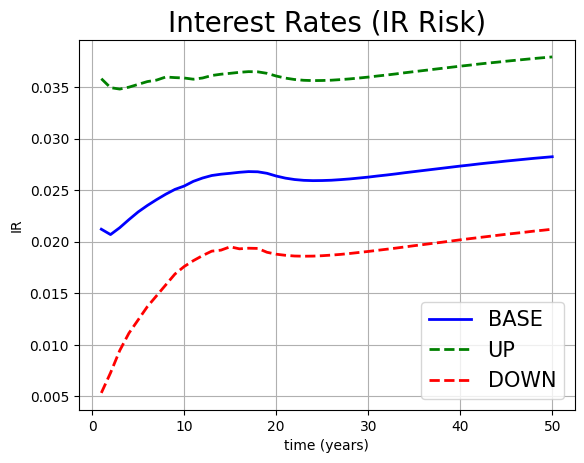

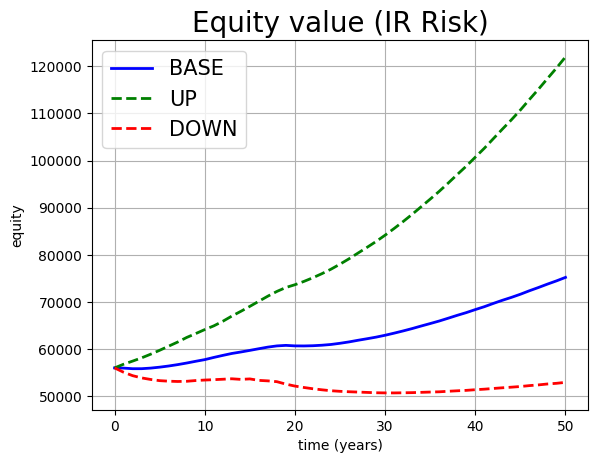

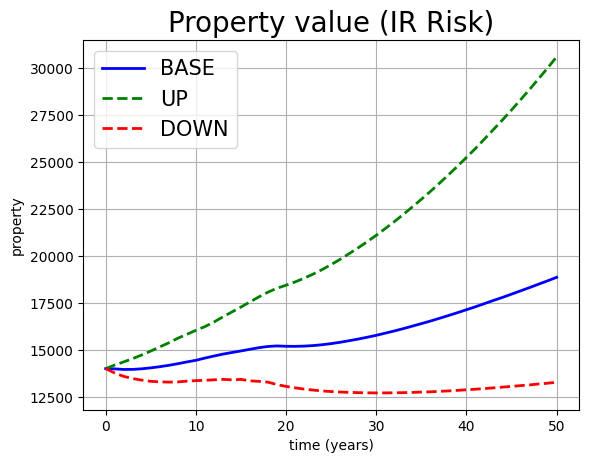

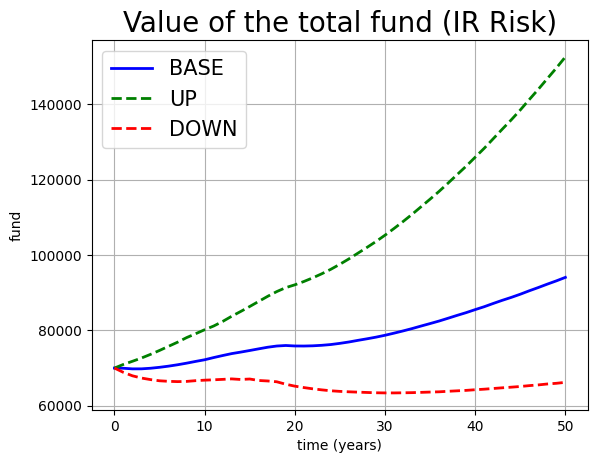

In [69]:
# --- Plot of Interest Rates ---
plt.figure()
plt.plot(t, zero_RFR, color='blue', label='BASE', linewidth=2)
plt.plot(t, zero_RFR_up, color='green', linestyle='--', label='UP', linewidth=2)
plt.plot(t, zero_RFR_down, color='red', linestyle='--', label='DOWN', linewidth=2)
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel('IR')
plt.title('Interest Rates (IR Risk)', fontsize=20)
plt.legend(fontsize=15)
plt.show()

# --- Plot of Equity Values ---
t_p = np.insert(t, 0, 0)  # t_p = [0; t]
plt.figure()
plt.plot(t_p, np.mean(EQ, axis=0), color='blue', label='BASE', linewidth=2)
plt.plot(t_p, np.mean(EQ_up, axis=0), color='green', linestyle='--', label='UP', linewidth=2)
plt.plot(t_p, np.mean(EQ_down, axis=0), color='red', linestyle='--', label='DOWN', linewidth=2)
plt.xlabel('time (years)')
plt.ylabel('equity')
plt.title('Equity value (IR Risk)', fontsize=20)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

# --- Plot of Property Values ---
plt.figure()
plt.plot(t_p, np.mean(PR, axis=0), color='blue', label='BASE', linewidth=2)
plt.plot(t_p, np.mean(PR_up, axis=0), color='green', linestyle='--', label='UP', linewidth=2)
plt.plot(t_p, np.mean(PR_down, axis=0), color='red', linestyle='--', label='DOWN', linewidth=2)
plt.xlabel('time (years)')
plt.ylabel('property')
plt.title('Property value (IR Risk)', fontsize=20)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

# --- Plot of Fund Values ---
plt.figure()
plt.plot(t_p, np.mean(F, axis=0), color='blue', label='BASE', linewidth=2)
plt.plot(t_p, np.mean(F_up, axis=0), color='green', linestyle='--', label='UP', linewidth=2)
plt.plot(t_p, np.mean(F_down, axis=0), color='red', linestyle='--', label='DOWN', linewidth=2)
plt.xlabel('time (years)')
plt.ylabel('fund')
plt.title('Value of the total fund (IR Risk)', fontsize=20)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

# 📉 Market equity Risk

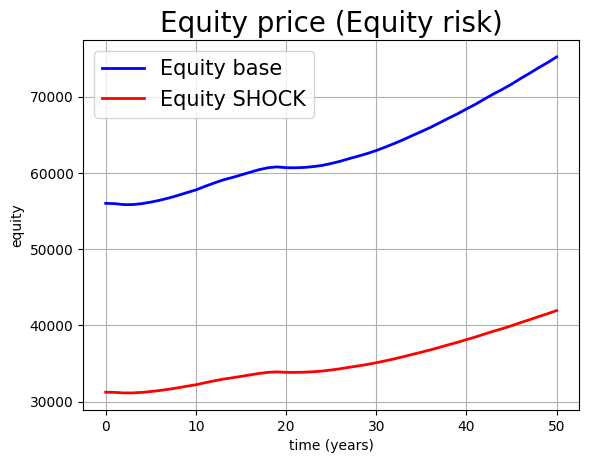

In [70]:
# Parameters
shock_type1 = 0.39  # type 1 equity shock (EIOPA)
symm_adj = 0.0525   # symmetric adjustment (March 2024)
equity_shock = (1 - shock_type1 - symm_adj) * EQ0  # shocked initial equity value
NMC = int(1e6)  # number of Monte Carlo simulations

# Simulate equity under shock
simulation_equity, _ = MonteCarlo(equity_shock, RD, R_fwd, sigma_equity, T, NMC)

# Compute liabilities using shocked equity + property
liabilities_equity, *_ = BEL_func(simulation_equity + PR, T, B, lapse, qx, lapse_penalties, expenses_inflation, RD, COMM)

F0_shock = equity_shock + PR0
BOF_equity_shock = F0_shock - liabilities_equity
dBOF_equity_shock = BOF - BOF_equity_shock
SCR_equity_shock = max(dBOF_equity_shock, 0)

# Plotting equity under base and shock scenarios
plt.figure()
plt.plot(t_p, np.mean(EQ, axis=0), color='blue', label='Equity base', linewidth=2)
plt.plot(t_p, np.mean(simulation_equity, axis=0), color='red', label='Equity SHOCK', linewidth=2)
plt.grid(True)
plt.legend(fontsize=15)
plt.title('Equity price (Equity risk)', fontsize=20)
plt.ylabel('equity')
plt.xlabel('time (years)')
plt.show()

# 🏠 Property Risk

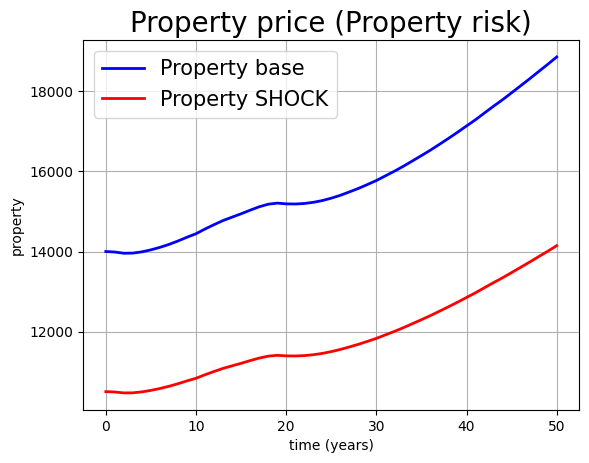

In [71]:
shock_property = 0.25
property_shock = (1 - shock_property) * PR0

NMC = int(1e6)  # Number of Monte Carlo simulations

# Simulate shocked property path
simulation_property, _ = MonteCarlo(property_shock, RD, R_fwd, sigma_property, T, NMC)

# Compute liabilities
liabilities_property, *_ = BEL_func( simulation_property + EQ , T, B, lapse, qx, lapse_penalties, expenses_inflation, RD, COMM )

# Compute BOF and SCR
F0_shock_p = EQ0 + property_shock
BOF_property_shock = F0_shock_p - liabilities_property
dBOF_property_shock = BOF - BOF_property_shock
SCR_property_shock = max(dBOF_property_shock, 0)

# Plot property price
plt.figure()
plt.grid(True)
plt.plot(t_p, np.mean(PR, axis=0), color='blue', linewidth=2,  label='Property base')
plt.plot(t_p, np.mean(simulation_property, axis=0), color='red', linewidth=2, label='Property SHOCK')
plt.legend(fontsize=15)
plt.title('Property price (Property risk)', fontsize=20)
plt.ylabel('property')
plt.xlabel('time (years)')
plt.show()


# 💸 Expenses Risk

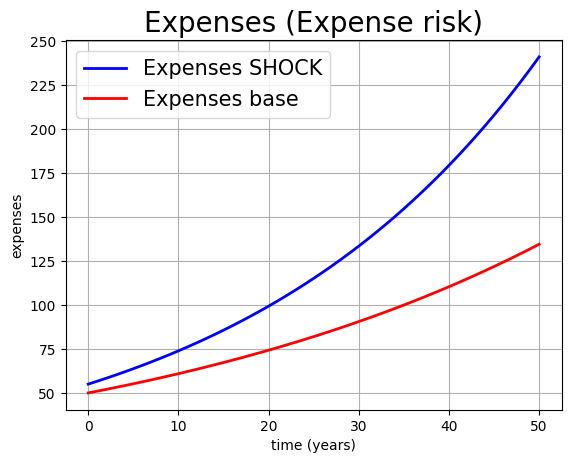

In [72]:
increase_expense = 0.1  # 10% shock
expense_shock = (1 + increase_expense) * expenses

NMC = int(1e6)  # Number of Monte Carlo simulations

# Shocked expenses growing with inflation + 1%
expenses_increased = np.concatenate([[expense_shock], expense_shock * (1 + (inflation_rate + 0.01)) ** t])

# Lapse penalty growing with inflation + 1%
lapse_increased = np.concatenate([[lapse_p], lapse_p * (1 + (inflation_rate + 0.01)) ** t])

# Compute liabilities with increased expenses
liabilities_expense, *_ = BEL_func( PR + EQ, T, B, lapse, qx, lapse_increased, expenses_increased, RD, COMM )

# Compute BOF and SCR
BOF_expense_shock = F0 - liabilities_expense
dBOF_expense_shock = BOF - BOF_expense_shock
SCR_expense_shock = max(dBOF_expense_shock, 0)

# Plotting expenses
plt.figure()
plt.grid(True)
plt.plot(t_p, expenses_increased, color='blue', linewidth=2, label='Expenses SHOCK')
plt.plot(t_p, expenses_inflation, color='red', linewidth=2, label='Expenses base')
plt.legend(fontsize=15)
plt.title('Expenses (Expense risk)', fontsize=20)
plt.ylabel('expenses')
plt.xlabel('time (years)')
plt.show()


# ⚰️ Mortality Risk

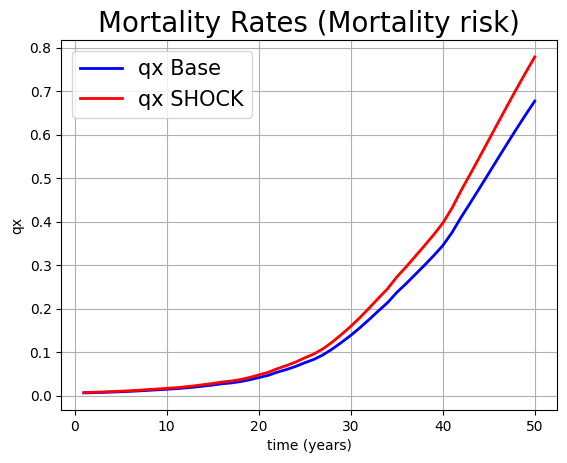

In [73]:
increase_mortality = 0.15  # 15% mortality shock
qx_mort = (1 + increase_mortality) * qx

# Compute liabilities under shocked mortality
liabilities_mortality, *_ = BEL_func(
    PR + EQ, T, B, lapse, qx_mort, lapse_penalties, expenses_inflation, RD, COMM
)

# BOF and SCR computation
BOF_mort_shock = F0 - liabilities_mortality
dBOF_mort_shock = BOF - BOF_mort_shock
SCR_mort_shock = max(dBOF_mort_shock, 0)

# Plot mortality rates
plt.figure()
plt.grid(True)
plt.plot(t, qx, color='blue', linewidth=2, label='qx Base')
plt.plot(t, qx_mort, color='red', linewidth=2, label='qx SHOCK')
plt.legend(fontsize=15)
plt.title('Mortality Rates (Mortality risk)', fontsize=20)
plt.ylabel('qx')
plt.xlabel('time (years)')
plt.show()


# 🚪 Lapse Risk

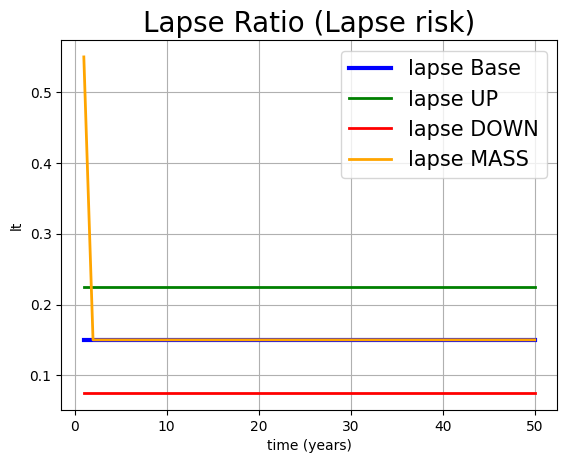

In [74]:
# Lapse shocks
lapse_up = np.minimum(1.5 * lt, 1.0) * np.ones(T)
lapse_down = np.maximum(0.5 * lt, lt - 0.2) * np.ones(T)
lapse_mass = np.concatenate([[lt + 0.4], lt * np.ones(T - 1)])

# Liabilities under different lapse shocks
liabilities_lapse_up, *_ = BEL_func(PR + EQ, T, B, lapse_up, qx, lapse_penalties, expenses_inflation, RD, COMM)
BOF_lapse_up = F0 - liabilities_lapse_up
dBOF_lapse_up = BOF - BOF_lapse_up
SCR_lapse_up = max(dBOF_lapse_up, 0)

liabilities_lapse_down, *_ = BEL_func(PR + EQ, T, B, lapse_down, qx, lapse_penalties, expenses_inflation, RD, COMM)
BOF_lapse_down = F0 - liabilities_lapse_down
dBOF_lapse_down = BOF - BOF_lapse_down
SCR_lapse_down = max(dBOF_lapse_down, 0)

liabilities_lapse_mass, *_ = BEL_func(PR + EQ, T, B, lapse_mass, qx, lapse_penalties, expenses_inflation, RD, COMM)
BOF_lapse_mass = F0 - liabilities_lapse_mass
dBOF_lapse_mass = BOF - BOF_lapse_mass
SCR_lapse_mass = max(dBOF_lapse_mass, 0)

# Plotting lapse scenarios
plt.figure()
plt.grid(True)
plt.plot(t, lt * np.ones(T), color='blue', linewidth=3, label='lapse Base')
plt.plot(t, lapse_up, color='green', linewidth=2, label='lapse UP')
plt.plot(t, lapse_down, color='red', linewidth=2, label='lapse DOWN')
plt.plot(t, lapse_mass, color='orange', linewidth=2, label='lapse MASS')
plt.legend(fontsize=15)
plt.title('Lapse Ratio (Lapse risk)', fontsize=20)
plt.ylabel('lt')
plt.xlabel('time (years)')
plt.show()

# Final SCR for lapse risk
BOF_lapse = min(BOF_lapse_mass, BOF_lapse_down, BOF_lapse_up)
SCR_lapse = max(BOF - BOF_lapse, 0)


# 🌪️ Catastrophe Risk

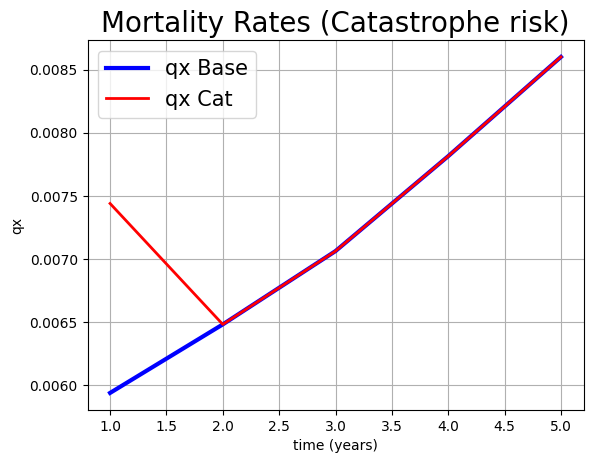

In [75]:
# Shock value
incr = 1.5 / 1000

# Apply catastrophe mortality shock
qx_cat = np.concatenate([[qx[0] + incr], qx[1:]])

# Compute liabilities under catastrophe mortality risk
liabilities_cat, *_ = BEL_func(PR + EQ, T, B, lapse, qx_cat, lapse_penalties, expenses_inflation, RD, COMM)

# Compute BOF and SCR
BOF_cat = F0 - liabilities_cat
dBOF_cat = BOF - BOF_cat
SCR_cat = max(dBOF_cat, 0)

# Plotting
plt.figure()
plt.grid(True)
plt.plot(t[0:5], qx[0:5], color='blue', linewidth=3, label='qx Base')
plt.plot(t[0:5], qx_cat[0:5], color='red', linewidth=2, label='qx Cat')
plt.legend(fontsize=15)
plt.title('Mortality Rates (Catastrophe risk)', fontsize=20)
plt.ylabel('qx')
plt.xlabel('time (years)')
plt.show()


# 🧮 Computation of BSCR

In [76]:
# SCR Market Module
market = np.array([SCR_IR, SCR_equity_shock, SCR_property_shock])

if SCR_IR == SCR_IR_up:
    corr_mkt = np.array([
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.75],
        [0.0, 0.75, 1.0]
    ])
else:
    corr_mkt = np.array([
        [1.0, 0.5, 0.5],
        [0.5, 1.0, 0.75],
        [0.5, 0.75, 1.0]
    ])

SCR_mkt = np.sqrt(market.T @ corr_mkt @ market)

# SCR Life Module
life = np.array([SCR_mort_shock, SCR_lapse, SCR_expense_shock, SCR_cat])

corr_life = np.array([
    [1.0, 0.0, 0.25, 0.25],
    [0.0, 1.0, 0.5, 0.25],
    [0.25, 0.5, 1.0, 0.25],
    [0.25, 0.25, 0.25, 1.0]
])

SCR_life = np.sqrt(life.T @ corr_life @ life)

# Basic Solvency Capital Requirement (BSCR)
SCR = np.array([SCR_mkt, SCR_life])

corr = np.array([
    [1.0, 0.25],
    [0.25, 1.0]
])

BSCR = np.sqrt(SCR.T @ corr @ SCR)

print('BSCR: ', BSCR)

BSCR:  2588.580237840946


# 🎲 Martingale Test

1e3 simulations loop took 0.0113 seconds
1e4 simulations loop took 0.0679 seconds
1e5 simulations loop took 0.7697 seconds
1e6 simulations loop took 8.3619 seconds


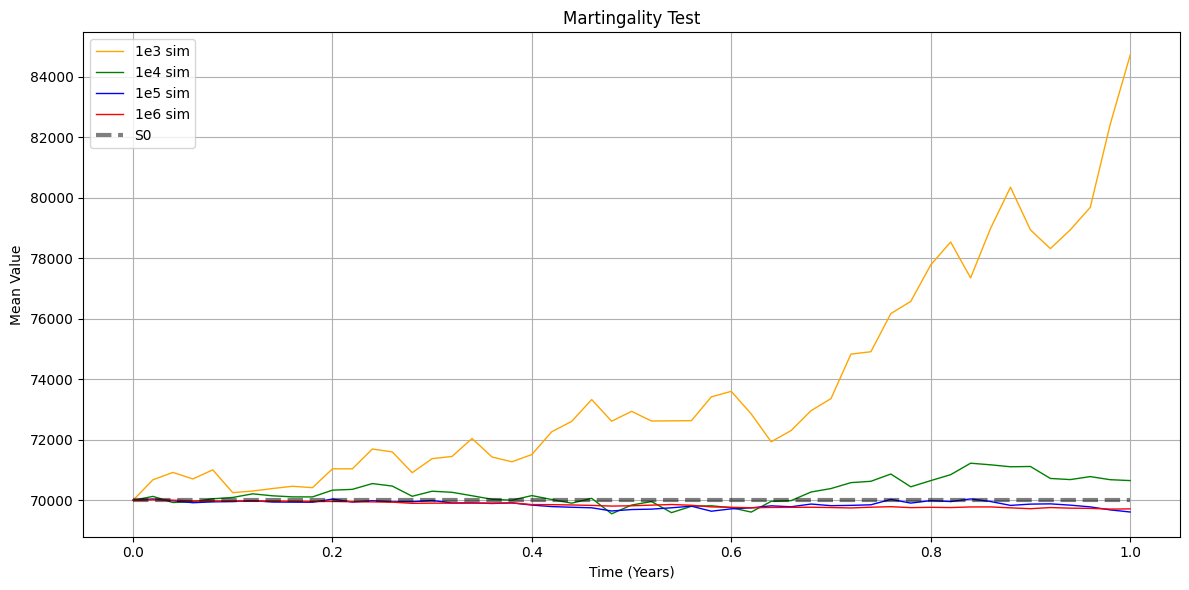

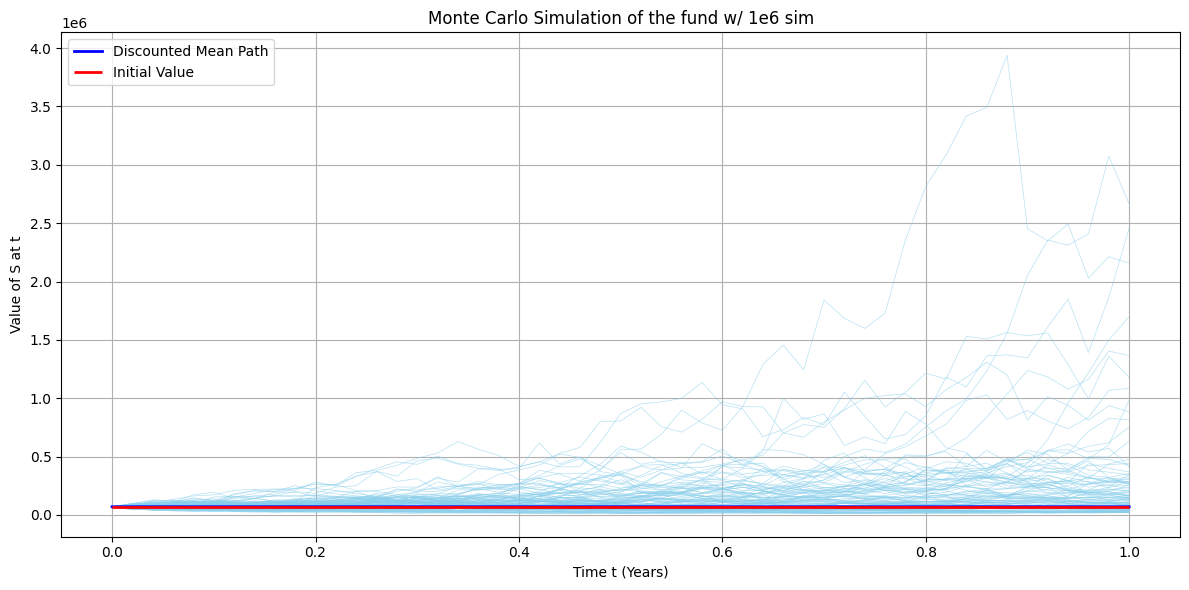

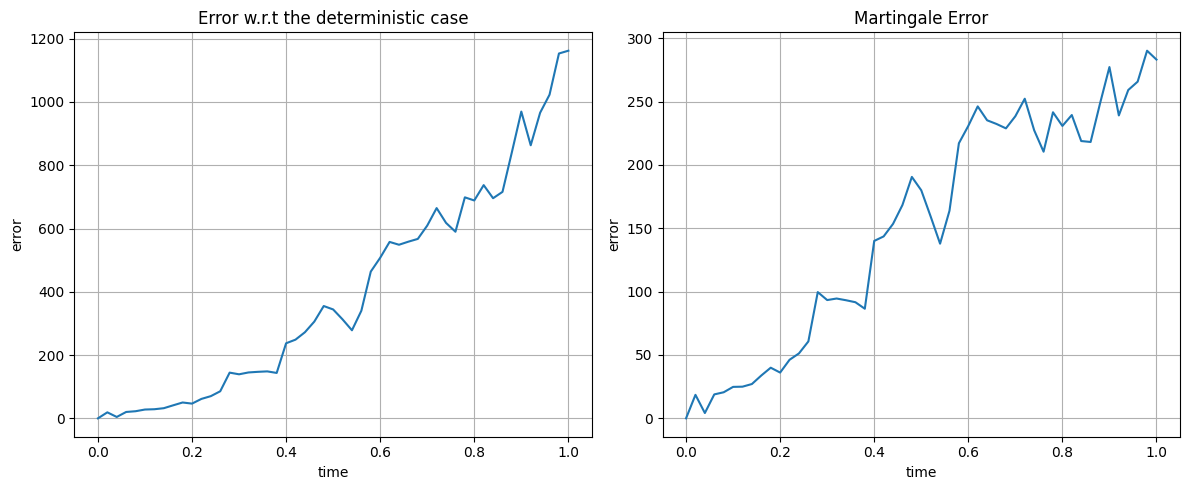

In [83]:
mtg_test(EQ0, PR0, R_fwd, sigma_equity, sigma_property, T, B)


# 🎯 RESULTS

In [78]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Scenario': [
        'Base Case', 
        'Interest Rate Up', 'Interest Rate Down',
        'Equity Down', 'Property Down', 
        'Expense Up', 'Mortality Up', 
        'Lapse Up', 'Lapse Down', 'Lapse Mass', 
        'CAT Shocked'
    ],
    'BOF': [
        BOF, 
        BOF_IR_up, BOF_IR_down, 
        BOF_equity_shock, BOF_property_shock, 
        BOF_expense_shock, BOF_mort_shock,
        BOF_lapse_up, BOF_lapse_down, BOF_lapse_mass, 
        BOF_cat
    ],
     'dBOF': [
        0, 
        dBOF_IR_up, dBOF_IR_down, 
        dBOF_equity_shock, dBOF_property_shock, 
        dBOF_expense_shock, dBOF_mort_shock,
        dBOF_lapse_up, dBOF_lapse_down, dBOF_lapse_mass, 
        dBOF_cat
    ],
    'SCR': [
        0, 
        SCR_IR_up, SCR_IR_down, 
        SCR_equity_shock, SCR_property_shock, 
        SCR_expense_shock, SCR_mort_shock,
        SCR_lapse_up, SCR_lapse_down, SCR_lapse_mass, 
        SCR_cat
    ]
})

print(results_df)

              Scenario          BOF         dBOF          SCR
0            Base Case  2157.863595     0.000000     0.000000
1     Interest Rate Up  2372.009952  -214.146357     0.000000
2   Interest Rate Down  1945.953683   211.909912   211.909912
3          Equity Down   222.072128  1935.791467  1935.791467
4        Property Down  1895.799025   262.064570   262.064570
5           Expense Up  2108.620680    49.242915    49.242915
6         Mortality Up  2051.144300   106.719295   106.719295
7             Lapse Up  1727.246033   430.617562   430.617562
8           Lapse Down  2354.166572  -196.302977     0.000000
9           Lapse Mass  1369.313108   788.550488   788.550488
10         CAT Shocked  2147.897431     9.966164     9.966164


The final results aggregate the 2 interest rate shocks and the 3 decay shocks being part of the same risk scenario, the corresponding SCR is the maximum among the relative SCRs

In [79]:
# Create a DataFrame to store the results
final_results_df = pd.DataFrame({
    'Risk Scenario': [
        'Base Case', 
        'Interest Rate',
        'Equity', 'Property', 
        'Expense', 'Mortality', 
        'Lapse',
        'Catastrophe'
    ],
    'BOF': [
        BOF, 
        BOF_IR,
        BOF_equity_shock, BOF_property_shock, 
        BOF_expense_shock, BOF_mort_shock,
        BOF_lapse,
        BOF_cat
    ],
    'SCR': [
        0, 
        SCR_IR,
        SCR_equity_shock, SCR_property_shock, 
        SCR_expense_shock, SCR_mort_shock,
        SCR_lapse,
        SCR_cat
    ]
})

print(final_results_df)

   Risk Scenario          BOF          SCR
0      Base Case  2157.863595     0.000000
1  Interest Rate  1945.953683   211.909912
2         Equity   222.072128  1935.791467
3       Property  1895.799025   262.064570
4        Expense  2108.620680    49.242915
5      Mortality  2051.144300   106.719295
6          Lapse  1369.313108   788.550488
7    Catastrophe  2147.897431     9.966164
